In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-09-04 01:36:03--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 2607:f8b0:400e:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   111MB/s    in 0.6s    

2019-09-04 01:36:04 (111 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [0]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.249.jpg', 'cat.884.jpg', 'cat.563.jpg', 'cat.942.jpg', 'cat.264.jpg', 'cat.478.jpg', 'cat.740.jpg', 'cat.654.jpg', 'cat.164.jpg', 'cat.289.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


In [0]:
print('total training cat images:', len(os.listdir(train_cats_dir))) 
print('total training dog images:', len(os.listdir(train_dogs_dir))) 
print('total validation cat images:', len(os.listdir(validation_cats_dir))) 
print('total validation dog images:', len(os.listdir(validation_dogs_dir))) 

#length of training and validation sets

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

#4x4 config for images

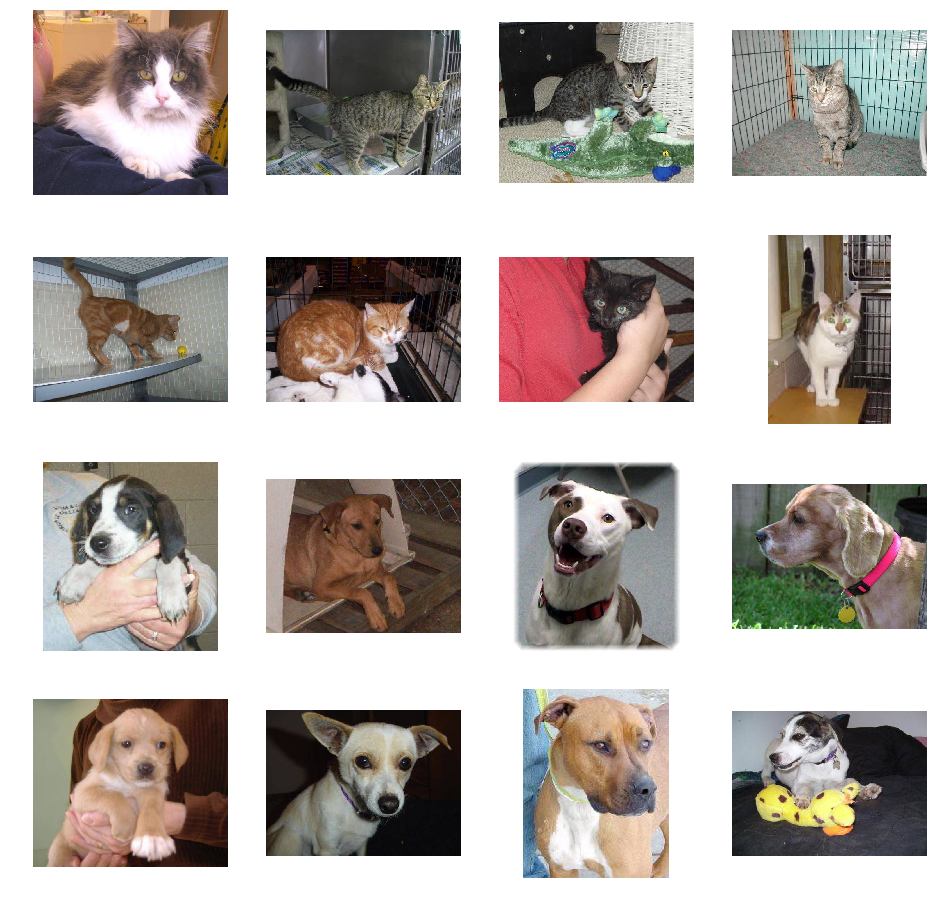

In [0]:

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 10
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]




next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [0]:
# save the final model to file
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# define cnn model
def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(150, 150, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

model = define_model()


In [0]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [0]:
#flows training images in batches of 20 at a time 
#resizes them to 0 to 1 range 


from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size = (150, 150),  # All images will be resized to 150x150
        batch_size = 64,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode = 'binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size = (150, 150),
        batch_size = 64,
        class_mode = 'binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch = len(train_dir),  # 2000 images = batch_size * steps
      epochs = 5,
      validation_data = validation_generator,
      validation_steps = len(validation_dir),  # 1000 images = batch_size * steps
      verbose = 1)





Epoch 1/5
33/33 [==============================] - 303s 9s/step - loss: 0.1800 - acc: 0.9364 - val_loss: 0.3070 - val_acc: 0.8618
Epoch 2/5
33/33 [==============================] - 302s 9s/step - loss: 0.1788 - acc: 0.9333 - val_loss: 0.2627 - val_acc: 0.9039
Epoch 3/5
33/33 [==============================] - 301s 9s/step - loss: 0.2001 - acc: 0.9273 - val_loss: 0.3288 - val_acc: 0.8684
Epoch 4/5
33/33 [==============================] - 302s 9s/step - loss: 0.2312 - acc: 0.8970 - val_loss: 0.2598 - val_acc: 0.8789
Epoch 5/5
33/33 [==============================] - 301s 9s/step - loss: 0.1991 - acc: 0.9197 - val_loss: 0.2698 - val_acc: 0.8763


In [0]:
_, acc = model.evaluate_generator(train_dir, steps=len(train_dir), verbose=0)
print(str((acc * 100.0)))
# learning curves
summarize_diagnostics(history)

TypeError: ignored

Text(0.5, 1.0, 'Training and validation loss')

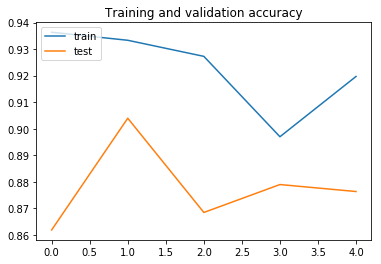

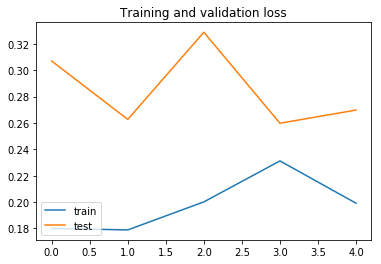

In [0]:

#accuracy results and training/validation loss

# Retrieve a list of accuracy results on training and test data
# sets for each trainin

acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))
#print(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.legend(['train', 'test'], loc='upper left')
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(['train', 'test'], loc='lower left')
plt.title('Training and validation loss')

In [0]:
from google.colab import files
uploaded = files.upload()

In [0]:
import numpy as np
from keras.preprocessing import image

def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
    
  return list(uploaded.keys())

upload_files()

my_file = '20190903_221320.jpg'

test_image = image.load_img(my_file, target_size=(150, 150))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)


if result[0][0] == 1:
  prediction = 'dog'
else:
  prediction = 'cat'
  




TypeError: ignored